#Линейная регрессия

Задание - обучить линейную регрессию предсказывать цену бриллиантов. Для обучения имеется датасет Diamonds_test.

Импорт всех необходимых библиотек и их составляющих:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics
from scipy import stats
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Импортирование датасета в датафрейм и проверка загрузки:

In [ ]:
#импорт происходит без столбца индекса, т.к. его полезность сомнительна
# data_frame = 
diamonds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diamonds_train.csv', index_col=0)

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,NaN,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# Предварительная обработка данных

С помощью  describe можно увидеть следующее:

1.   Присутствуют пропуски в столбце depth.
2.   В параметрах x, y и z очевидно имеются выбросы (ошибочные), от которых лучше избавиться наравне с выбросами, имеющими сильно отличающиеся от средних значений.

Помимо прочего, cut, color и clarity - категориальные данные, которые надо будет заменить числовыми значениями.



In [ ]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43081.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.850243,61.756391,57.483732,4445.475552,5.829285,5.831401,3.598703
std,0.511738,1.421175,2.213001,4300.607758,1.211473,1.229739,0.750341
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.370000,61.100000,56.000000,878.000000,4.630000,4.630000,2.840000
50%,0.900000,61.900000,57.000000,3465.000000,6.060000,6.050000,3.740000
75%,1.130000,62.500000,59.000000,6301.250000,6.700000,6.690000,4.130000
max,5.010000,78.200000,95.000000,18823.000000,10.740000,58.900000,8.060000


Для того чтобы заменить категориальные данные на числовые, воспринимаемые регрессией, узнаем все их возможные значения:

In [ ]:
print('Возможнные значения cut:', diamonds['cut'].unique())
print('Возможнные значения color:', diamonds['color'].unique())
print('Возможнные значения clarity:', diamonds['clarity'].unique())

Возможнные значения cut: ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
Возможнные значения color: ['E' 'I' 'J' 'H' 'F' 'G' 'D']
Возможнные значения clarity: ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [ ]:
#словарь, задающий соответствие категориальных данных коэффициентам (коэффициенты основаны на данных из Википедии, от менее ценных к более ценным)
values = { 'cut': {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}, 
          'color':{'J': 7, 'I': 6, 'H': 5, 'G': 4, 'F': 3, 'E': 2, 'D': 1},
          'clarity': {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}}

#непосредственно замена (в независимый от оригинала датафрейм)
df_rwrkd = diamonds
df_rwrkd.replace(values, inplace= True)

С помощью графиков можно увидеть, что абсолютное большинство алмазов имеет параметр depth, находящийся в очень небольном диапазоне, а цена от него зависит не слишком сильно, соответственно заполнение пропусков медианным значением нас полностью устроит.

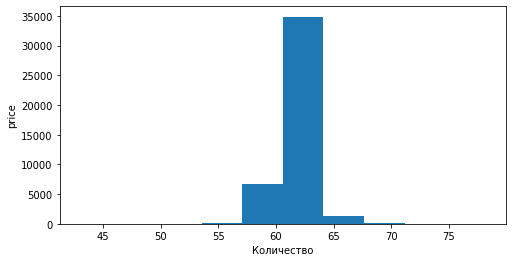

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(diamonds['depth'])
plt.xlabel('Количество')
plt.ylabel('price')
plt.show()

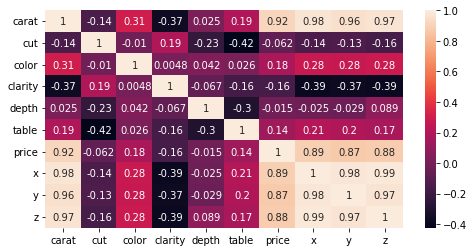

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(diamonds.corr(), annot = True)

In [ ]:
df_rwrkd['depth'].fillna(df_rwrkd['depth'].median(), inplace = True)

In [ ]:
df_rwrkd.drop(columns = ['depth'], inplace = True)

Удаление дубликатов:

In [ ]:
df_rwrkd.drop_duplicates(inplace = True)

Очистка от выбросов z-методом:

In [ ]:
df_rwrkd = df_rwrkd[(np.abs(stats.zscore(df_rwrkd)) < 3).all(axis = 1)]

Разделение на обучающую и тестовую части:

In [ ]:
#входные вектора для разделения
X = df_rwrkd.drop(columns = 'price')
Y = np.log(df_rwrkd['price'])

X_train, x_test, Y_train, y_test = train_test_split(X, Y, train_size = 0.8)

Нормализация:

In [ ]:
names = X_train.columns

scaled_df = pd.DataFrame(preprocessing.normalize(X_train, axis = 0), columns = names)

# Обучение и тестирование регрессии

In [ ]:
#создание экземпляра класса регрессии
linear_regression = LinearRegression()
linear_regression.fit(X_train, Y_train)

LinearRegression()

In [ ]:
print('Score обучения линейной регрессии:', linear_regression.score(X_train, Y_train))

Score обучения линейной регрессии: 0.9803660743869047


Посмотрим коэффициенты зависимости price от других параметров:

In [ ]:
pd.DataFrame({'coef': linear_regression.coef_}, index=X_train.columns)

,coef
carat,-1.119995
cut,0.024667
color,-0.077834
clarity,0.121737
table,0.009226
x,0.557937
y,0.272089
z,0.990317


Попробуем предсказать результат на тестовых данных и сравним его с образцом:

In [ ]:
y_pred = linear_regression.predict(x_test)

prediction = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
prediction.head()

,Actual,Predicted
26668,9.710631,9.700585
14844,8.695674,8.569924
21734,9.190240,9.546776
21807,9.198065,9.185319
38997,6.960348,6.950748


In [ ]:
#разные метрики для сравнения
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Score тестирования линейной регрессии:', linear_regression.score(x_test, y_test))

MAE: 0.11809041738465459
MSE: 0.022445610271735188
RMSE: 0.14981859120861865
Score тестирования линейной регрессии: 0.9808092304469151
